<a href="https://colab.research.google.com/github/kazuma-kosuge/clone/blob/master/%E7%A4%BE%E4%BC%9A%E3%82%B7%E3%83%9F%E3%83%A5%E3%83%AC%E3%83%BC%E3%82%B7%E3%83%A7%E3%83%B3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import random as rnd
import numpy as np
import networkx as nx
import pandas as pd
import gym
import math

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#drive_root_dir="drive/My Drive/Data/study"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [51]:
class Agent:
    def __init__(self,alpha_normal,gamma_normal):
        self.point = 0.0
        #pre_の初期値設定が以下二つ
        self.now_state = 2#initializeで半分半分に定義しているため
        self.now_action = None#Simulationのinitializeで定義している
        #self.next_strategy = None 
        #self.neighbors_id = []
        #学習率と割引率をエージェントごとに特有とする
        self.alpha = alpha_normal#0.2# #学習率
        self.gamma = 0.99 if gamma_normal > 0.99 else gamma_normal#0.99 #割引率
        #↑コメントアウトしてあるものはalphaとgammaを個体ごとで帰る場合

    def softmax(self,x):
      x = x/20　#Q値がでかいため、割って調整
      #xの最大値で引く,すべてをマイナスにする→全部マイナスだから打ち消す
      return np.exp(x)/np.sum(np.exp(x),axis=0,keepdims=True)

    def decide_next_strategy(self, now_state):
      #Q_tableからCorDを導出
      self.now_state = now_state #現状の状態を各個人が記憶する
      choice = self.softmax(self.q_table[now_state])
      print(choice)
      self.now_action = np.random.choice([0,1],p = choice)

    def update_strategy(self):#Qの更新を行う関数
      #now_action時の「即時報酬」
      Reward = self.pre_point

      #Qtable更新
      self.q_table[self.pre_state,self.pre_action] = (1- self.alpha) * self.q_table[self.pre_state,self.pre_action] \
      + self.alpha * (Reward + self.gamma * self.q_table[self.now_state,self.now_action])

      #一回前の状態と行動を保持しておく
      self.pre_state = self.now_state
      self.pre_action = self.now_action

In [52]:
class Simulation:
  def __init__(self,population):
    self.agents = self.__generate_agents(population)
    self.initialize = self.__initialize()

    for focal in self.agents:
      focal.q_table = np.random.uniform(low=1000, high=1010, size=(5,2))

  def __generate_agents(self,population):
    #rearange_edges = average_degree//2
    #network = nx.barabasi_albert_graph(population, rearange_edges)

    alpha_normal = np.random.normal(0.2,0.05,population)
    gamma_normal = np.random.normal(0.94,0.05,population)
    agents = [Agent(alpha_normal[id],gamma_normal[id]) for id in range(population)]
    #for index, focal in enumerate(agents):
      #neighbors_id = list(network[index])  # list()無しだとgeneratorになってしまうので注意
      #for agent_id in neighbors_id:
        #focal.neighbors_id.append(agent_id)

    return agents

  def __initialize(self):
    population = len(self.agents)
    initialize = rnd.sample(range(population), k = int(population/2))

    return initialize

  def initialize_strategy(self):
      for index, focal in enumerate(self.agents):
        if index in self.initialize:#配列の中にindexがいたら
          focal.now_action = 0 #"C"
        else:
          focal.now_action = 1 #"D"

  def count_payoff(self):
        #特定の回の全エージェントが獲得する利得を計算

        for focal in self.agents:
            focal.point = 0.0
            k = np.random.choice([-60,30],p=[0.5,0.5])

            if focal.now_action == 0: #"C":
              focal.point = self.count_fc()#self.sumC()/len(self.agents)
            else:
              focal.point = self.count_fc() + k

  def update_strategy(self):
        """全エージェントに戦略を更新させる"""
        now_state = self.count_fc()
        #小数点切り捨て
        #state = int(math.floor(state))

        #stateを5段階にする
        if now_state <= 20:
          now_state = 0
        elif now_state > 20 and now_state <=40:
          now_state = 1
        elif now_state > 40 and now_state <=60:
          now_state = 2
        elif now_state >60 and now_state <= 80:
          now_state = 3
        else:
          now_state = 4

        for focal in self.agents:
            #pre_action = focal.strategy
            focal.decide_next_strategy(now_state)
            focal.pre_point = focal.point

        for focal in self.agents:
            focal.update_strategy()

        
        self.count_payoff()
        

  def count_fc(self):
        """C戦略エージェントの割合を計算"""
        #このagent.strategy==0はの0は"C"
        fc = (len([agent for agent in self.agents if agent.now_action == 0])/len(self.agents)) * 100
        return fc

  def play_game(self, episode):
        """一つのパラメータ設定で協調率が収束するまで計算"""
        #初期化
        self.initialize_strategy()
        #C戦略の割合計算
        self.__count_payoff()
        fc = self.count_fc()
        fc_hist = [fc]
        print(f"Episode:{episode}, Time: 0, Fc:{fc:.3f}//初期化")
        print(self.agents[0].q_table)

        result = pd.DataFrame({'time': [], 'fc': []})
        
        for focal in self.agents:
          focal.pre_state = focal.now_state
          focal.pre_action = focal.now_action

        #↑ここまでstateは存在せず、actionはinitializeによって決められている。↑
        #time0の際の初期設定だけ回している
        #print(self.agents[0].now_action)
        #print(self.agents[0].point)

        tmax = 1000
        for t in range(1,tmax):
            #self.count_payoff()
            self.update_strategy()
            fc = self.count_fc()
            fc_hist.append(fc)
            print(f"Episode:{episode}, Time:{t}, Fc:{fc:.3f},Cstrategy:{self.agents[0].now_action},point:{self.agents[0].point}")
            #print(self.agents[0].now_action)
            #print(self.agents[0].point)
            new_result = pd.DataFrame([[t,format(fc,'.3f')]],columns=['time','fc'])
            result = result.append(new_result)

            ##### 収束判定 #####
            # 100回以上戦略更新を繰り返し、過去100回のゲームで得られた協調率の平均値と次のゲームでの協調率の差が十分小さくなったら計算を打ち切る
            if (t >= 100 and np.absolute(np.mean(fc_hist[t-100:t-1]) - fc)/fc < 0.001) or t == tmax-1:
                fc_converged = np.mean(fc_hist[t-99:t])  # 過去100回分のゲームで得られた協調率の平均値を取る
                break

            #振動したら終わり
            elif t>= 100 and fc_hist[t] == fc_hist[t-2] and fc_hist[t] == fc_hist[t-4] and fc_hist[t] == fc_hist[t-6]:
              fc_converged = fc
              print("振動")
              break


            # 囚人のジレンマゲームでは全員C戦略 or 全員D戦略の状態に収束しやすいため、そうなったらすぐに計算を打ち切る
            elif fc in [0, 100]:
                fc_converged = fc
                break

        #print(f"Dr:{Dr:.1f}, Dg:{Dg:.1f}, Time:{t}, Fc:{fc_converged:.3f}")
        print(f" Time:{t}, Fc:{fc_converged:.3f}")
        filename = f"drive/My Drive/Data/Study/episode{episode}.csv"
        result.to_csv(filename,index=False)

        return fc_converged
        
#  def run_one_episode(self, episode):
    #result = pd.DataFrame({'Dg': [], 'Dr': [], 'Fc': []})
    #self.__choose_initial_cooperators()

#    for Dr in range(1):#np.arange(0, 1.1, 0.1)
#      for Dg in range(1):#np.arange(0.1, 1.1, 0.1)
#        fc_converged = self.play_game(episode,Dr,Dg)
        #new_result = pd.DataFrame([[format(Dg, '.1f'), format(Dr, '.1f'), fc_converged]], columns = ['Dg', 'Dr', 'Fc'])
        #result = result.append(new_result)


    #result.to_csv("drive/My Drive/Data/Study")

In [53]:
class Teams:#元institutes
  def __init__(self,team_num):
    self.team_num = team_num
    #self.fc_set

    self.team = self.__generate_team()
    #print(self.team[0].agents[0].now_action)
  
  def __generate_team(self):
    team = [Simulation(50) for index in range(self.team_num)]
    return team

  def __initialize_first_game(self,episode):
    #self.result = pd.DataFrame({'time': [], 'fc': []})
    for index,focal in enumerate(self.team):
      #初期化
      focal.initialize_strategy()
      #C戦略の割合計算
      focal.count_payoff()
      fc = focal.count_fc()
      self.fc_hist = [fc]
      #print(f"Episode:{episode}, Time: 0, Team:{index} , Fc:{fc:.3f}//初期化")
      #print(focal.agents[0].q_table)

      
      
      for focal2 in focal.agents:
        focal2.pre_state = focal2.now_state
        focal2.pre_action = focal2.now_action

  def first_game(self,episode,time):
    self.this_time_result = pd.DataFrame({'fc': []})
    for index,focal in enumerate(self.team):
      focal.update_strategy()
      fc = focal.count_fc()
      self.fc_hist.append(fc)
      #print(f"Episode:{episode}, Time:{time}, team:{index}, Fc:{fc:.3f},Cstrategy:{focal.agents[0].now_action},point:{focal.agents[0].point}")
      #this_result = pd.DataFrame([[time,format(fc,'.3f')]],columns=['time','fc'])
      result = pd.DataFrame([[format(fc,'.3f')]],columns=['fc'])
      self.this_time_result = self.this_time_result.append(result)


  #def second_game(self,episode,time):for index,focal in enumerate(self.team):
  
  def play_all_game(self,episode):
    self.__initialize_first_game(episode)
    #print(self.team[0].agents[0].now_action)

    for t_now in range(10):
      self.first_game(episode,t_now)
      print(self.this_time_result)

In [54]:
def run():
    population = 50          # エージェント数
    num_episode = 10            # シミュレーションの試行回数
    team_num = 5
    simulation = Teams(team_num)

    for episode in range(num_episode):
      rnd.seed()
      simulation.play_all_game(1)
      #print(simulation.team[0].agents[0].q_table)



if __name__ == '__main__':
    run()

ストリーミング出力は最後の 5000 行に切り捨てられました。
[0.43715147 0.56284853]
[0.45188928 0.54811072]
[0.65146778 0.34853222]
[0.45321685 0.54678315]
[0.72278972 0.27721028]
[0.55740174 0.44259826]
[0.6382333 0.3617667]
[0.39148632 0.60851368]
[0.87189953 0.12810047]
[0.46735412 0.53264588]
[0.55069456 0.44930544]
[0.53093097 0.46906903]
[0.97175521 0.02824479]
[9.99996747e-01 3.25294800e-06]
[0.51208329 0.48791671]
[0.48860059 0.51139941]
[0.99233828 0.00766172]
[0.99365132 0.00634868]
[0.58880808 0.41119192]
[0.37173926 0.62826074]
[0.85608963 0.14391037]
[0.44225084 0.55774916]
[0.99831136 0.00168864]
[0.33419291 0.66580709]
[9.99999965e-01 3.52087188e-08]
[0.68897526 0.31102474]
[0.67597511 0.32402489]
[9.99999889e-01 1.11390937e-07]
[0.73690658 0.26309342]
[0.57741117 0.42258883]
[0.60993863 0.39006137]
[0.94830826 0.05169174]
[0.72304988 0.27695012]
[0.62986316 0.37013684]
[0.71651247 0.28348753]
[0.42724268 0.57275732]
[0.51343505 0.48656495]
[0.4580267 0.5419733]
[4.64570097e-04 9.99535430e-01]
[0.8

過去のコード

In [ ]:
def run():
    population = 50          # エージェント数
    average_degree = 8          # 社会ネットワークの平均次数
    num_episode = 10            # シミュレーションの試行回数
    simulation = Simulation(population, average_degree)

    for episode in range(num_episode):
        rnd.seed()
        simulation.play_game(episode)
        print(simulation.agents[0].q_table)


#self.q_table = np.random.uniform(low=-1, high=1, size=(5,2))

#下のq_tableだと全体で学習が共有される。alphaとgammaを大きくずらさない限り一瞬で収束する。
#現実の状態としては知の共有とかいえるかもしれないけど、今回は転職でやってるのでなし

#q_table = np.random.uniform(low=-1, high=1, size=(5,2))

if __name__ == '__main__':
    run()



In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


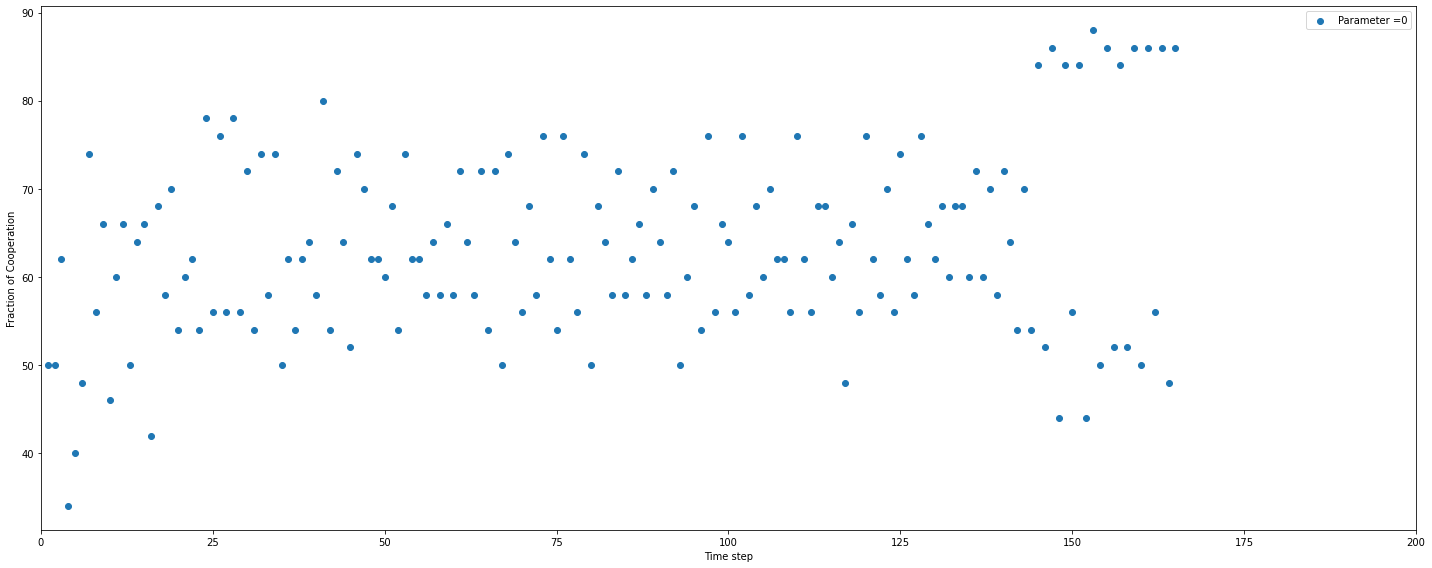

In [ ]:
num_figure = 1    # 描画したいcsvファイルの数

fig = plt.figure(figsize=(20, 8))

for i in range(0, num_figure):
    df = pd.read_csv('drive/My Drive/Data/Study/episode{}.csv'.format(i))    # csvファイル読み込み
    ax = fig.add_subplot(111)
    ax.scatter(df['time'], df['fc'], label='Parameter ={}'.format(i))
    ax.set_xlabel('Time step')
    ax.set_ylabel('Fraction of Cooperation')
    ax.set_xlim([0, 200])

plt.legend()
plt.tight_layout()
#plt.savefig('time_series_data.png')
plt.show()

